# py_interior-point.ipynb
## modified from Lecture 5 of CMU16-745 (2025)


Solve inequality constraint case using interior point method.

In [34]:
import numpy as np 
import matplotlib.pyplot as plt 
#from numpy.linalg import norm, solve
import jax
import jax.numpy as jnp
from jax.numpy.linalg import norm, solve # I actually don't know the difference

In [49]:
Q = np.diag([0.5,1])
Q
# objective function
def f(x):
    x1 = jnp.array(x) - jnp.array([[1],[0]])
    return 0.5*(x1.T@Q@x1)[0,0]

# gradient 
def df(x):
    x1 = jnp.array(x) - jnp.array([[1],[0]])
    return Q@x1

# hessian 
def d2f(x):
    return Q


In [107]:
# constraint and gradient
A = jnp.array([-1.0, 1.0]).reshape(2,1)
print(A.shape)
b = 1.0
             
def c(x):
    return (jnp.dot(A.T,x) - b)

def dc(x):
    return A  


(2, 1)


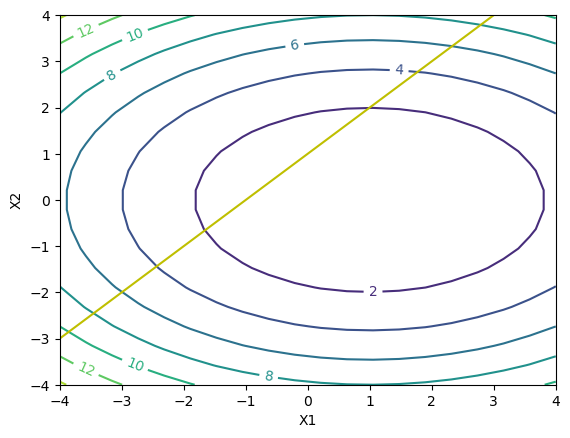

In [4]:
def plot_landscape():
    Nsamp = 20
    x = np.linspace(-4,4,Nsamp)
    y = np.linspace(-4,4,Nsamp)
    X, Y = np.meshgrid(x,y)
    Z = np.zeros((Nsamp,Nsamp))
    for j in range(Nsamp):
        for k in range(Nsamp):
            Z[j,k] = f([[X[j,k]], [Y[j,k]]])
    fig, ax = plt.subplots()
    CS = ax.contour(X,Y,Z)
    ax.clabel(CS, fontsize = 10)

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')

    xc = np.linspace(-4,3, Nsamp)
    yc = xc+1
    ax.plot(xc,yc,'y-')

    return ax

ax = plot_landscape()   

In [118]:
def ip_residual(z, rho):
    x = z[0:2]
    sigma = z[2]
    ru = df(x) - dc(x).T.reshape(2,1)*jnp.sqrt(rho)*jnp.exp(-sigma)
    rl = c(x) - jnp.sqrt(rho)*jnp.exp(sigma)
    r = jnp.vstack((ru,rl))
    return r

In [47]:
# wrapper function to handle JAX forwarddiff 
def ip_residual_wrapper(z):
    global rho_global
    return ip_residual(z, rho_global)
    

In [30]:
def kkt_residual(z):
    x = z[0:2]
    sigma = z[2]
    Lambda = np.sqrt(rho)*np.exp(-sigma)

    ru = df(x) - dc(x).T.reshape(2,1)*Lambda
    r = np.vstack((ru,np.minimum(Lambda,0),np.minimum(c(x),0),Lambda*c(x)))
    return r

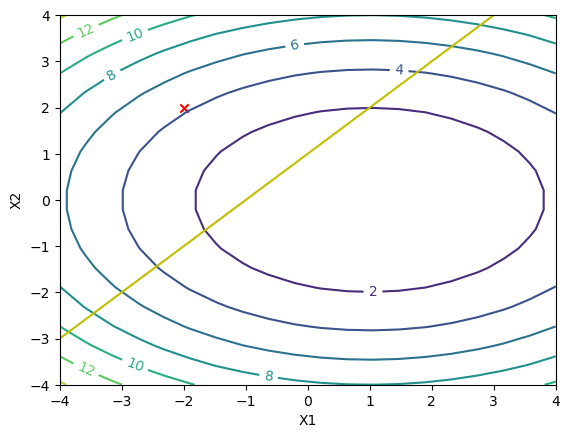

In [134]:
xguess = np.array([[-2.0],[2.0]])
sigmaguess = [0.0]
z = np.vstack((xguess, sigmaguess))
ax = plot_landscape()
ax.scatter(z[0], z[1],marker='x',color='r')
z_iter = z

In [31]:
rho = 1.0
ip_residual(z,rho)

array([[-0.5],
       [ 1. ],
       [ 2. ]])

In [32]:
kkt_residual(z)

array([[-0.5],
       [ 1. ],
       [ 0. ],
       [ 0. ],
       [ 3. ]])

In [130]:
def ip_newton_solve(z0,rho,tol,debug=0):
    global rho_global

    rho_global = rho
    # initial guess
    z = z0

    # KKT residual
    r = ip_residual(z,rho)
    if debug:
        print("r = ")
        print(r)

    while norm(r) > tol:
        if debug:
            print("==========================================")
            print("norm(r) = ")
            print(norm(r))

        # Newton step
        M = jnp.asarray(jax.jacfwd(ip_residual_wrapper)(z)).reshape(3,3)
        if debug:
            print("M = ")
            print(M)
            print(M.shape)
        dz = solve(-M,r)
        if debug:
            print("dz = ")
            print(dz)

        znew = z + dz
        if debug:
            print("znew = ")
            print(znew)
        rnew = ip_residual(znew,rho)
        if debug:
            print("rnew = ")
            print(rnew)

        # line search
        b = 0.1
        d = 0.5
        alpha = 1.0
        norm_r = norm(r)
        while norm(rnew) > (norm_r + b*alpha*jnp.dot(r.T,M@dz)/norm_r):
            alpha = d*alpha
            znew = z + alpha*dz
            rnew = ip_residual(znew,rho)

        z = znew
        r = rnew

    return z
        

In [142]:
# function to plot each optimization step.
# modified for better visualization.
def plot_steps(xguess):
    ax = plot_landscape()
    ax.scatter(xguess[0,:], xguess[1,:],marker='x',color='g') 
    ax.scatter(xguess[0,-1], xguess[1,-1],marker='x',color='r')
    for ix in range(xguess.shape[1]-1):
        x1_old = xguess[0,ix]
        x1_new = xguess[0,ix+1]
        x2_old = xguess[1,ix]
        x2_new = xguess[1,ix+1]
        # print("x1_old = {}, x1_new = {}, x2_old = {}, x2_new = {}".format(x1_old,x1_new,x2_old,x2_new))
        if np.linalg.norm(xguess[:,ix] - xguess[:,ix+1]).item() > 0.1: # plot arrow if distance large enough
            ax.arrow(x1_old,x2_old,(x1_new-x1_old)/2,(x2_new-x2_old)/2,head_width=0.1,color='m')
    ax.plot(xguess[0,:], xguess[1,:],'m')    

In [139]:
rho = 0.001
z = ip_newton_solve(z_iter[:,-1].reshape(3,1), rho, 1e-6,debug=1)
z_iter = np.hstack((z_iter,z))

r = 
[[-0.6420526 ]
 [ 0.64205265]
 [ 0.1261578 ]]
norm(r) = 
0.9167218
M = 
[[ 0.5         0.         -0.0713392 ]
 [ 0.          1.          0.0713392 ]
 [-1.          1.         -0.01401754]]
(3, 3)
dz = 
[[ 0.1578703 ]
 [-0.07893527]
 [-7.8935204 ]]
znew = 
[[-0.26891327]
 [ 0.6344566 ]
 [-8.707088  ]]
rnew = 
[[ 1.9054468e+02]
 [-1.9054468e+02]
 [-9.6635386e-02]]
norm(r) = 
0.26705036
M = 
[[ 0.5         0.         -0.51328224]
 [ 0.          1.          0.51328224]
 [-1.          1.         -0.00194825]]
(3, 3)
dz = 
[[ 0.05307311]
 [-0.02653655]
 [-0.2997166 ]]
znew = 
[[-0.33424288]
 [ 0.6671214 ]
 [-3.0866647 ]]
rnew = 
[[ 2.5540769e-02]
 [-2.5540769e-02]
 [-7.9474295e-05]]
norm(r) = 
0.03612019
M = 
[[ 0.5         0.         -0.6926622 ]
 [ 0.          1.          0.6926622 ]
 [-1.          1.         -0.00144371]]
(3, 3)
dz = 
[[-8.8413974e-05]
 [ 4.4202432e-05]
 [ 3.6809526e-02]]
znew = 
[[-0.3343313 ]
 [ 0.66716564]
 [-3.0498552 ]]
rnew = 
[[ 4.6354532e-04]
 [-4.6354532e-0

In [140]:
z_iter

array([[-2.        , -1.        , -0.42678356, -0.33433262],
       [ 2.        ,  1.        ,  0.71339184,  0.66716629],
       [ 0.        ,  0.        , -0.81356823, -3.04916191]])

In [141]:
kkt_residual(z)

array([[ 1.1920929e-07],
       [-1.1920929e-07],
       [ 0.0000000e+00],
       [ 0.0000000e+00],
       [ 1.0000408e-03]], dtype=float32)

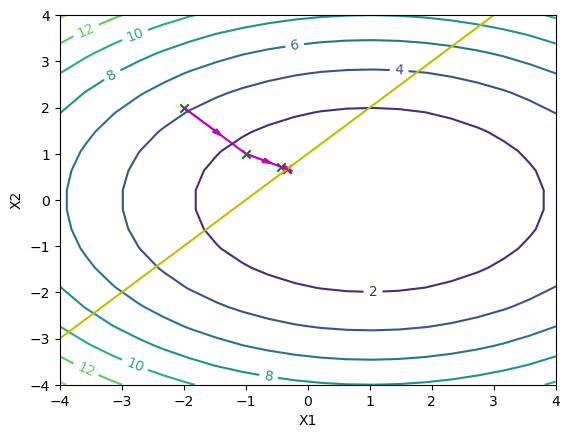

In [143]:
plot_steps(z_iter)

In [68]:
M = jnp.asarray(jax.jacfwd(ip_residual_wrapper)(z)).reshape(3,3)
M

Array([[ 0.5,  0. , -1. ],
       [ 0. ,  1. ,  1. ],
       [-1. ,  1. , -1. ]], dtype=float32)

In [ ]:
jnp.linalg.eig(M)